In [11]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [12]:
# File paths
dataset_path = 'datatrain_40/total'
input_file = os.path.join(dataset_path, 'trainx.txt')
output_path = os.path.join(dataset_path, "data_augmentation")

In [13]:
def save_txt_data(data, file_path):
    """
    Save data to a .txt file.
    
    :param data: numpy array of shape (n_samples, 1680)
    :param file_path: str, path to save the .txt file
    """
    try:
        os.makedirs(os.path.dirname(file_path), exist_ok=True)
        np.savetxt(file_path, data, fmt='%.6f', delimiter=' ')
    except IOError as e:
        print(f"Error saving file {file_path}: {e}")
        raise

def load_txt_data(file_path):
    """
    Load data from a .txt file.
    
    :param file_path: str, path to the .txt file
    :return: numpy array of shape (n_samples, 1680)
    """
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    data = []
    for line in lines:
        # Split the line by whitespace and convert to float
        values = [float(val) for val in line.strip().split()]
        if len(values) != 1680:
            raise ValueError(f"Expected 1680 values per line, but got {len(values)}")
        data.append(values)
    
    return np.array(data)

In [14]:

def jitter(data, noise_factor=0.05):
    """
    Apply jittering to the input data.
    
    :param data: numpy array of shape (n_samples, 1680)
    :param noise_factor: float, amount of noise to add (default: 0.05)
    :return: jittered data with the same shape as input
    """
    noise = np.random.normal(loc=0, scale=noise_factor, size=data.shape)
    jittered_data = data + noise * np.abs(data)
    return jittered_data

def scale(data, scaling_factor=0.1):
    """
    Apply random scaling to the input data.
    
    :param data: numpy array of shape (n_samples, 1680)
    :param scaling_factor: float, maximum scaling factor (default: 0.1)
    :return: scaled data with the same shape as input
    """
    factors = np.random.uniform(1 - scaling_factor, 1 + scaling_factor, size=(data.shape[0], 1))
    scaled_data = data * factors
    return scaled_data

def shift(data, max_shift=10):
    """
    Apply random time shift to the input data.
    
    :param data: numpy array of shape (n_samples, 1680)
    :param max_shift: int, maximum number of time steps to shift (default: 10)
    :return: time-shifted data with the same shape as input
    """
    shifted_data = np.zeros_like(data)
    for i in range(data.shape[0]):
        shift = np.random.randint(-max_shift, max_shift + 1)
        shifted_data[i] = np.roll(data[i], shift)
    return shifted_data

def magnitude_warp(data, sigma=0.2, knot=4):
    """
    Apply magnitude warping to the input data.
    
    :param data: numpy array of shape (n_samples, 1680)
    :param sigma: float, standard deviation of the warping (default: 0.2)
    :param knot: int, number of knot points for warping (default: 4)
    :return: magnitude-warped data with the same shape as input
    """
    from scipy.interpolate import CubicSpline
    
    warped_data = np.zeros_like(data)
    time_steps = 240  # Assuming 240 time steps per sensor
    
    for i in range(data.shape[0]):
        time_points = np.arange(time_steps)
        knot_points = np.linspace(0, time_steps - 1, knot)
        coeffs = np.random.normal(loc=1.0, scale=sigma, size=(7, knot))  # 7 sensors
        
        for j in range(7):  # For each sensor
            spline = CubicSpline(knot_points, coeffs[j])
            warps = spline(time_points)
            warped_data[i, j*time_steps:(j+1)*time_steps] = data[i, j*time_steps:(j+1)*time_steps] * warps
    
    return warped_data

def combine_augmentations(data, techniques=['jitter', 'scale', 'shift', 'warp'], **kwargs):
    """
    Apply multiple augmentation techniques to the input data.
    
    :param data: numpy array of shape (n_samples, 1680)
    :param techniques: list of strings, techniques to apply (default: all)
    :param kwargs: additional arguments for each technique
    :return: augmented data with the same shape as input
    """
    augmented_data = data.copy()
    
    if 'jitter' in techniques:
        augmented_data = jitter(augmented_data, kwargs.get('noise_factor', 0.05))
    if 'scale' in techniques:
        augmented_data = scale(augmented_data, kwargs.get('scaling_factor', 0.1))
    if 'shift' in techniques:
        augmented_data = shift(augmented_data, kwargs.get('max_shift', 10))
    if 'warp' in techniques:
        augmented_data = magnitude_warp(augmented_data, kwargs.get('sigma', 0.2), kwargs.get('knot', 4))
    
    return augmented_data



In [15]:
current_techniques = [jitter, scale, shift, magnitude_warp]

In [68]:
def plot_the_first_sample(data_array, timestep, label_index = 5):
    plot_data = []
    for data in data_array:
        temp = data[:timestep, label_index]
        plot_data.append(temp)
    
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    axs = axs.ravel()
    time_points = np.arange(timestep)
    
    axs[0].plot(time_points, plot_data[0])
    axs[0].set_title('Original Data')
    axs[0].set_xlabel('Time Steps')
    axs[0].set_ylabel('Amplitude')

    print(len(plot_data))

    for i in range(len(current_techniques)):
        data = plot_data[i]
        axs[i+1].plot(time_points, data)
        axs[i+1].set_title(current_techniques[i].__name__)
        axs[i+1].set_xlabel('Time Steps')
        axs[i+1].set_ylabel('Amplitude')
    fig.delaxes(axs[5])
    
    # Adjust layout
    plt.tight_layout()
    plt.show()


In [61]:
timestep = 240

# Load the input data
original_data = load_txt_data(input_file)
augmented_data = [original_data]

# Apply the base techniques
for technique in current_techniques:
    data = technique(original_data)
    augmented_data.append(data)
    file_name = f"{technique.__name__}.txt"
    full_path = os.path.join(output_path, file_name)
    save_txt_data(data, full_path)

# Select a pair of techniques to combine
for i in range(len(current_techniques)):
    for j in range(i+1, len(current_techniques)):
        technique1 = current_techniques[i]
        technique2 = current_techniques[j]
        data = technique1(original_data)
        data = technique2(data)
        file_name = f"{technique1.__name__}_{technique2.__name__}.txt"
        full_path = os.path.join(output_path, file_name)
        save_txt_data(data, full_path)

 


5


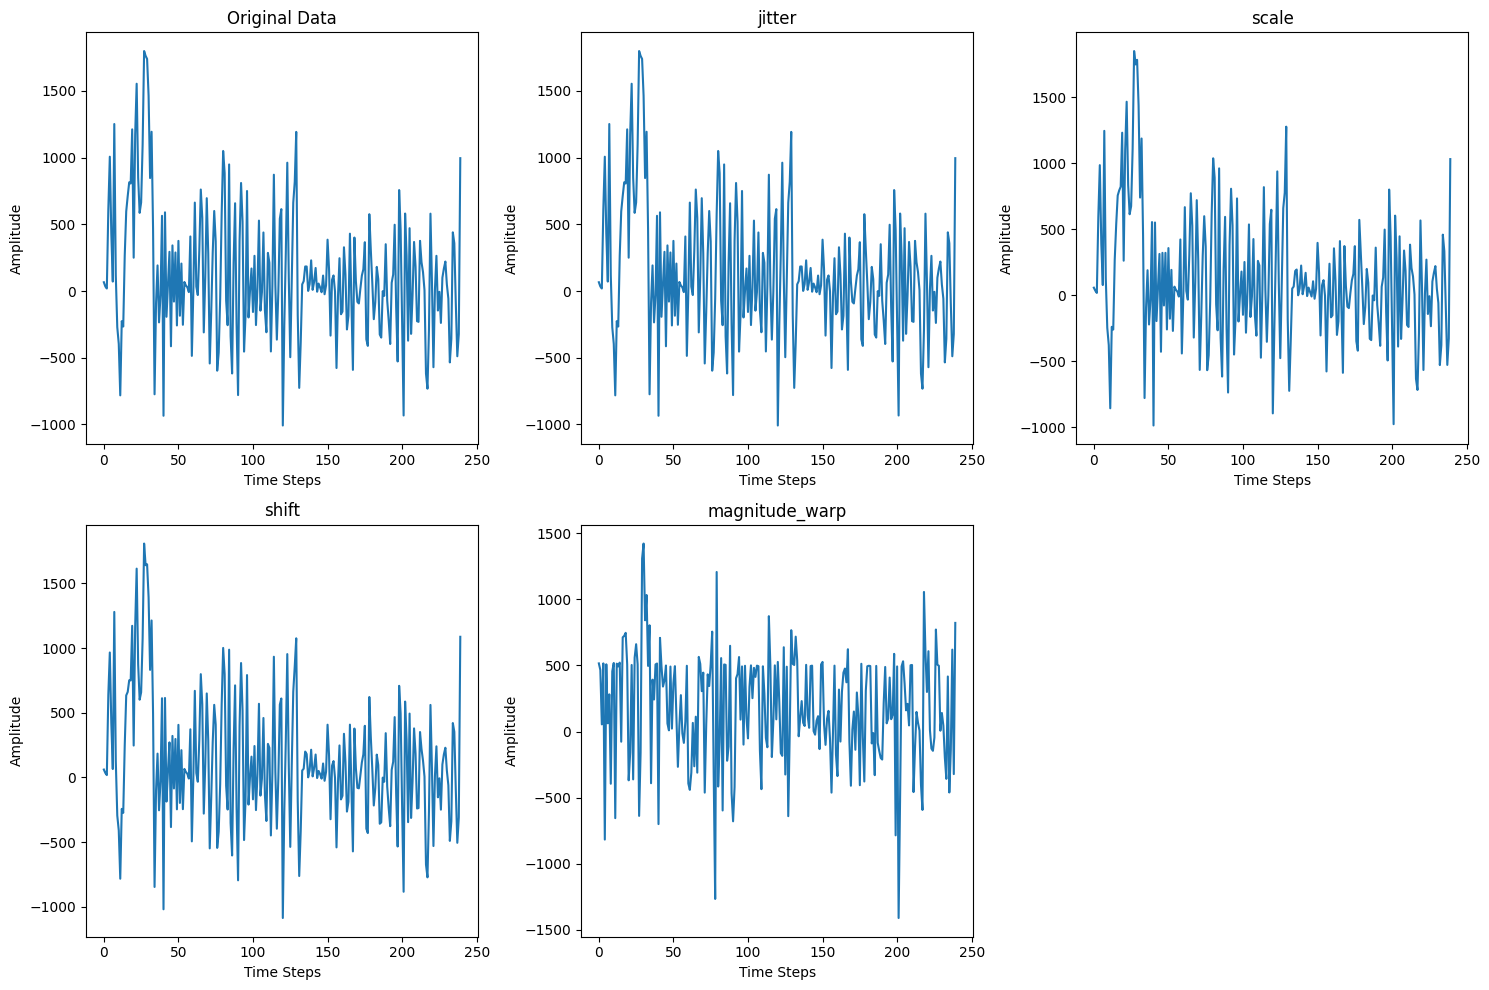

In [69]:
plot_the_first_sample(augmented_data, timestep)   